<h1><center><font size="6">Preprocessing Notebook</font></center></h1>


# Importing Packages

In [ ]:
# UPLOAD UTILS, PREPROCESS AND LABELLED_DATA.CSV TO COLAB BEFORE EXECUTUION

In [ ]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
import re as regex
import pickle

# import plotly
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text.tsne import tsne
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob, Word


%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../py")
from utils import *
from preprocess import *

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
from IPython.core.display import HTML

def plot_histogram(df, column, nbins, title, xtitle, ytitle):
    # Create the figure with subplots
    fig = make_subplots(rows=1, cols=1)

    # Add the histogram trace to the figure
    fig.add_trace(go.Histogram(x=df[column], nbinsx=nbins, name=column))

    # Update the layout of the figure
    fig.update_layout(title=title,
                      xaxis_title=xtitle,
                      yaxis_title=ytitle)

    # Save the plot to an HTML file and return it as a string
    html_str = pyo.plot(fig,filename = column+"_plot.html")

    # Return the HTML code as a string
    return HTML(html_str)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_histogram4(df, column, nbins, title, xtitle, ytitle):
    # Set the plot style and background color
    sns.set_style('whitegrid')
    sns.set_palette('colorblind')
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_facecolor('#f0f0f0')

    # Create the histogram plot using seaborn
    ax = sns.histplot(data=df, x=column, bins=nbins, color='#3182bd', alpha=0.8)

    # Set the plot title and axis labels
    ax.set_title(title, fontsize=20, fontweight='bold')
    ax.set_xlabel(xtitle, fontsize=14)
    ax.set_ylabel(ytitle, fontsize=14)

    # # Add labels to the end of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2, height), ha='center', va='center', xytext=(0, 15), textcoords='offset points', rotation=90, fontsize=12)

    # Add a grid to the plot
    ax.grid(axis='y', linestyle='-', alpha=0.4)

    # Add a border around the plot
    for spine in ax.spines.values():
        spine.set_edgecolor('#dddddd')
        spine.set_linewidth(1.5)

    # Save the plot to a file and show it
    fig.savefig(column + '_plot.png', bbox_inches='tight')
    plt.show()


# Original Dataset

In [ ]:
df = pd.read_csv("/content/combined_data.csv")
df.head()

,tweet,target
0,Drasko they didn't cook half a bird you idiot ...,1
1,Hopefully someone cooks Drasko in the next ep ...,1
2,of course you were born in serbia...you're as ...,1
3,These girls are the equivalent of the irritati...,1
4,RT @YesYoureRacist: At least you're only a tin...,1


In [ ]:
df.shape

(30770, 2)

In [ ]:
df = df.rename(columns={"hate_speech": 'hate', "offensive_language": 'offensive', "neither": 'neutral', "class": 'target'})
df.head()

,tweet,target
0,Drasko they didn't cook half a bird you idiot ...,1
1,Hopefully someone cooks Drasko in the next ep ...,1
2,of course you were born in serbia...you're as ...,1
3,These girls are the equivalent of the irritati...,1
4,RT @YesYoureRacist: At least you're only a tin...,1


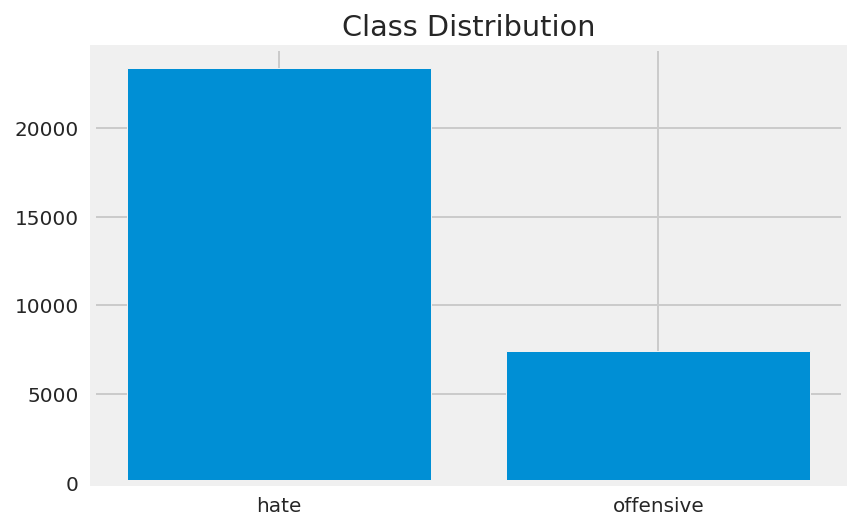

In [ ]:
hate = len(df[df['target'] == 0])
off = len(df[df['target'] == 1])
# neu = len(df[df['target'] == 2])
classes = ["hate", "offensive"]
count = [hate, off]

plt.bar(classes, count)
plt.title("Class Distribution")
plt.show()

# EDA and Feature Engineering

In [ ]:
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

In [ ]:
df.tweet.head(30)

0     Drasko they didn't cook half a bird you idiot ...
1     Hopefully someone cooks Drasko in the next ep ...
2     of course you were born in serbia...you're as ...
3     These girls are the equivalent of the irritati...
4     RT @YesYoureRacist: At least you're only a tin...
5     @MisfitInChains @oldgfatherclock @venereverita...
6     RT @Dreamdefenders: Eric Holder from #ferguson...
7     RT @AntonioFrench: I spent the morning at the ...
8     RT @harikondabolu: In his #Ferguson testimony,...
9     "He can't be a server at our restaurant, that ...
10    @GarrettaBrown85 @5Candrew Why do people even ...
11                These two are revolting #MKR #MKR2015
12    The menus look like they were made by a 5 year...
13    Wish these blondes were in that How To Get Awa...
14    Were butchers but can't tell red poultry is no...
15    Not dumb blondes...mmm...perhaps just delusion...
16    Stop saying dumb blondes with pretty faces as ...
17    #mkr Omg there restaurant looks like a a l

## Word Count Per Tweet

In [ ]:
def num_of_words(df, col):
    df['word_ct'] = df[col].apply(lambda x: len(str(x).split(" ")))
    print(df[[col, 'word_ct']])

num_of_words(df, 'tweet')

                                                   tweet  word_ct
0      Drasko they didn't cook half a bird you idiot ...       10
1      Hopefully someone cooks Drasko in the next ep ...       10
2      of course you were born in serbia...you're as ...       14
3      These girls are the equivalent of the irritati...       18
4      RT @YesYoureRacist: At least you're only a tin...       19
...                                                  ...      ...
30765  you's a muthaf***in lie &#8220;@LifeAsKing: @2...       19
30766  you've gone and broke the wrong heart baby, an...       13
30767  young buck wanna eat!!.. dat nigguh like I ain...       13
30768              youu got wild bitches tellin you lies        7
30769  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...       18

[30770 rows x 2 columns]


In [ ]:
df.word_ct.value_counts().sort_values(ascending=False)

11    1559
10    1558
9     1555
12    1507
13    1479
7     1466
8     1455
14    1343
18    1325
16    1315
15    1279
6     1196
17    1189
21    1150
19    1137
20    1123
23    1109
22    1087
5     1029
24     938
25     853
4      775
26     709
27     520
3      479
28     327
29     244
2      222
30     128
31      77
44      54
36      44
42      39
41      39
32      38
40      36
45      35
38      33
47      33
43      33
33      32
35      31
48      29
37      28
39      26
46      22
49      20
34      19
50      12
1       11
52       7
51       4
53       4
57       3
70       1
56       1
59       1
60       1
55       1
Name: word_ct, dtype: int64

In [ ]:
df

,tweet,target,word_ct
0,Drasko they didn't cook half a bird you idiot ...,1,10
1,Hopefully someone cooks Drasko in the next ep ...,1,10
2,of course you were born in serbia...you're as ...,1,14
3,These girls are the equivalent of the irritati...,1,18
4,RT @YesYoureRacist: At least you're only a tin...,1,19
...,...,...,...
30765,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,0,19
30766,"you've gone and broke the wrong heart baby, an...",0,13
30767,young buck wanna eat!!.. dat nigguh like I ain...,0,13
30768,youu got wild bitches tellin you lies,0,7


In [ ]:
plot_histogram(df, 'word_ct', 40, 'Word Count Distribution', 'Word Count', 'Count')

Output hidden; open in https://colab.research.google.com to view.

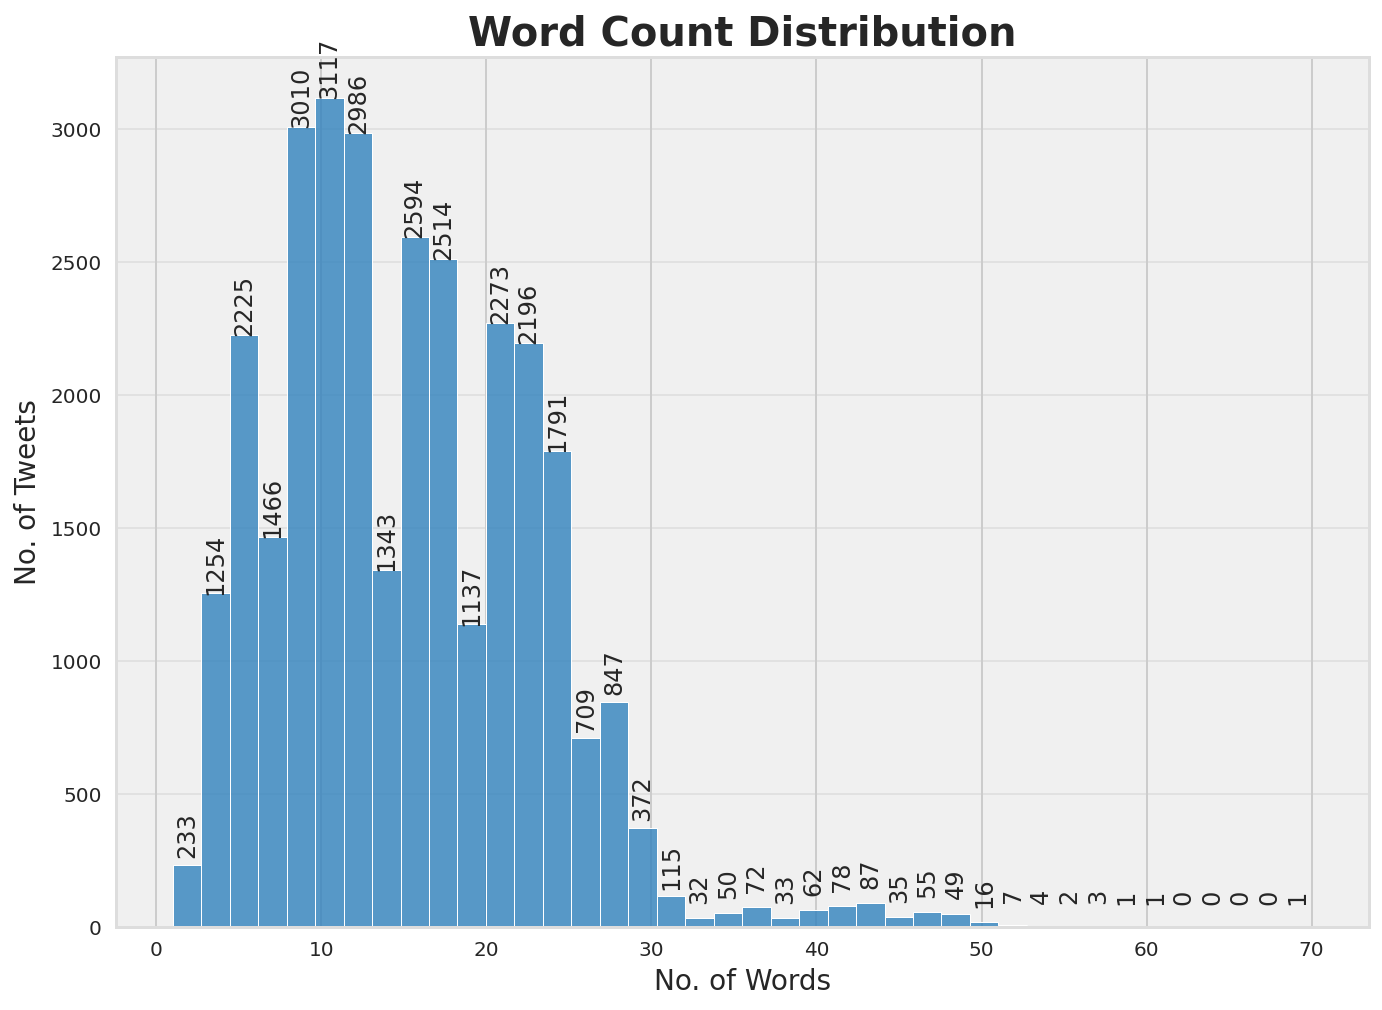

In [ ]:
plot_histogram4(df, 'word_ct', 40, 'Word Count Distribution', 'No. of Words', 'No. of Tweets')

## Number of Characters Per Tweet

In [ ]:
def num_of_chars(df, col):
    df['char_ct'] = df[col].str.len()
    print(df[[col, 'char_ct']])

num_of_chars(df, 'tweet')

                                                   tweet  char_ct
0      Drasko they didn't cook half a bird you idiot ...     50.0
1      Hopefully someone cooks Drasko in the next ep ...     53.0
2      of course you were born in serbia...you're as ...     75.0
3      These girls are the equivalent of the irritati...     99.0
4      RT @YesYoureRacist: At least you're only a tin...    102.0
...                                                  ...      ...
30765  you's a muthaf***in lie &#8220;@LifeAsKing: @2...    146.0
30766  you've gone and broke the wrong heart baby, an...     70.0
30767  young buck wanna eat!!.. dat nigguh like I ain...     67.0
30768              youu got wild bitches tellin you lies     37.0
30769  ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...    127.0

[30770 rows x 2 columns]


In [ ]:
df.char_ct.value_counts().sort_values(ascending=False)

140.0    1002
146.0     806
139.0     420
138.0     331
77.0      294
         ... 
754.0       1
447.0       1
455.0       1
343.0       1
341.0       1
Name: char_ct, Length: 343, dtype: int64

In [ ]:
plot_histogram(df, 'char_ct', 100, 'Character Count Distribution', 'No. of Characters', 'No. of Tweets')

Output hidden; open in https://colab.research.google.com to view.

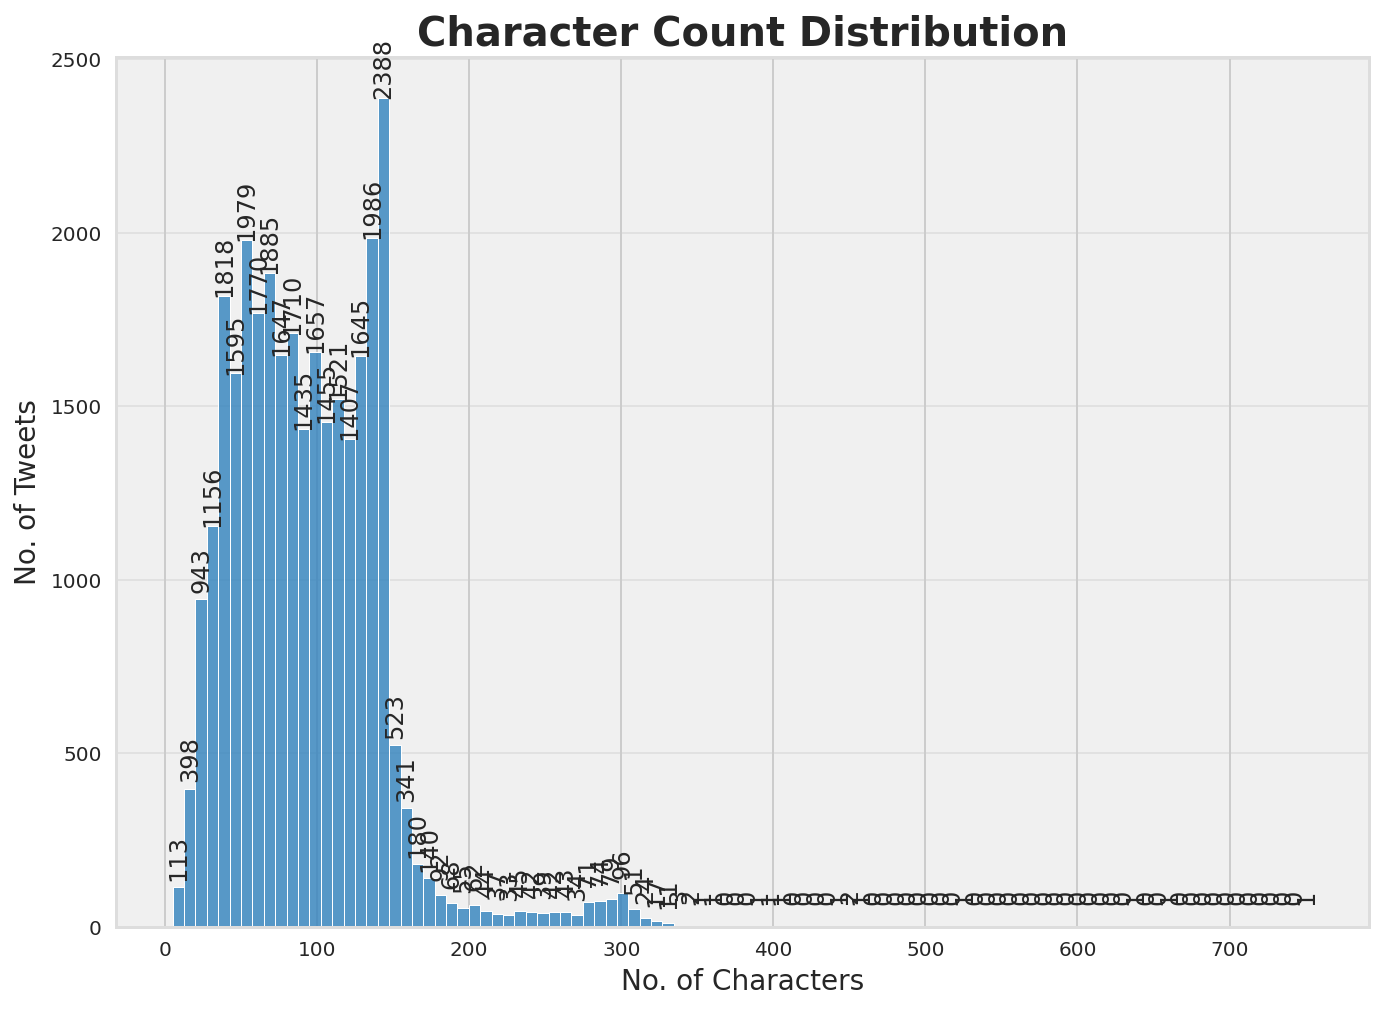

In [ ]:
plot_histogram4(df, 'char_ct', 100, 'Character Count Distribution', 'No. of Characters', 'No. of Tweets')

## Average Word Length Per Tweet

In [ ]:
def avg_word(sentence):
    words = str(sentence).split()
    return (sum(len(word) for word in words)/len(words))

def avg_word_length(df, col):
    df['avg_wrd'] = df[col].apply(lambda x: avg_word(x))
    print(df[[col, 'avg_wrd']].head())

avg_word_length(df, 'tweet')

                                               tweet   avg_wrd
0  Drasko they didn't cook half a bird you idiot ...  4.100000
1  Hopefully someone cooks Drasko in the next ep ...  4.400000
2  of course you were born in serbia...you're as ...  4.428571
3  These girls are the equivalent of the irritati...  4.555556
4  RT @YesYoureRacist: At least you're only a tin...  4.421053


In [ ]:
plot_histogram(df, 'avg_wrd', 60, 'Average Word Length Distribution', 'Average Word Length', 'Count')

Output hidden; open in https://colab.research.google.com to view.

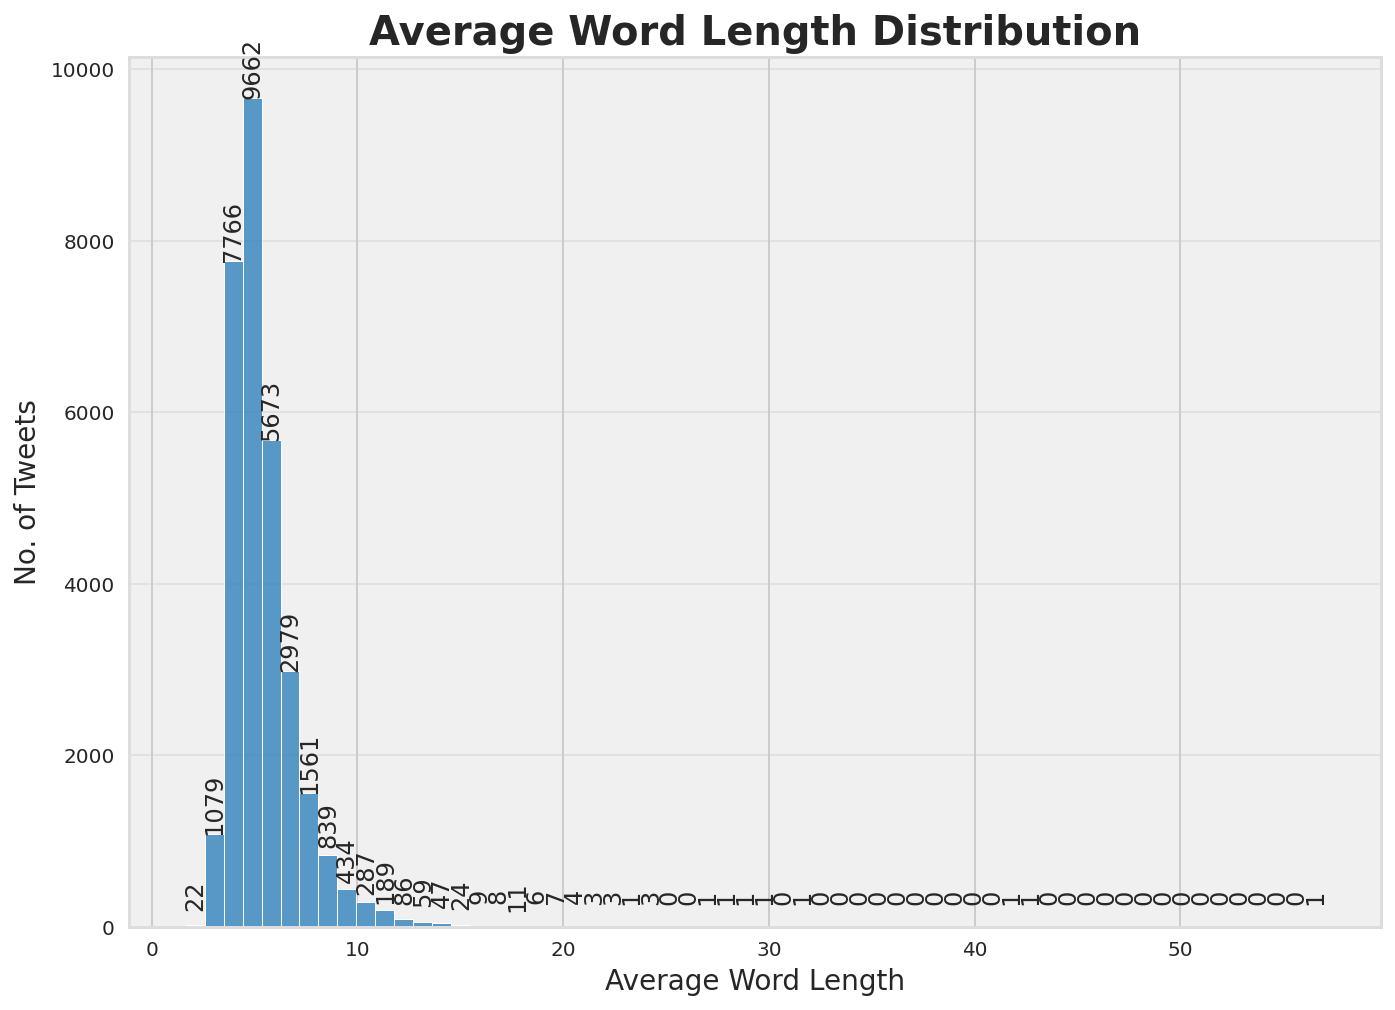

In [ ]:
plot_histogram4(df, 'avg_wrd', 60, 'Average Word Length Distribution', 'Average Word Length', 'No. of Tweets')

## Hashtags Count

In [ ]:
import re
def hash_tags(df, col):
    df['hashtags'] = df[col].apply(lambda x: len(re.split(r'#', str(x)))-1)
    print(df[[col, 'hashtags']].head())

hash_tags(df, 'tweet')

                                               tweet  hashtags
0  Drasko they didn't cook half a bird you idiot ...         1
1  Hopefully someone cooks Drasko in the next ep ...         1
2  of course you were born in serbia...you're as ...         1
3  These girls are the equivalent of the irritati...         1
4  RT @YesYoureRacist: At least you're only a tin...         0


In [ ]:
df.hashtags.value_counts()

0     20808
1      4386
2      2346
3      1231
4       696
5       423
6       273
7       203
8       121
9        78
10       50
13       36
11       27
12       24
15       19
14       14
24        4
18        4
17        3
16        3
23        3
27        2
47        2
25        2
21        1
36        1
20        1
77        1
40        1
22        1
66        1
19        1
65        1
39        1
63        1
28        1
Name: hashtags, dtype: int64

In [ ]:
plot_histogram(df, 'hashtags', 60, 'Hashtags Distribution', 'No. of Hashtags', 'No. of Tweets')

Output hidden; open in https://colab.research.google.com to view.

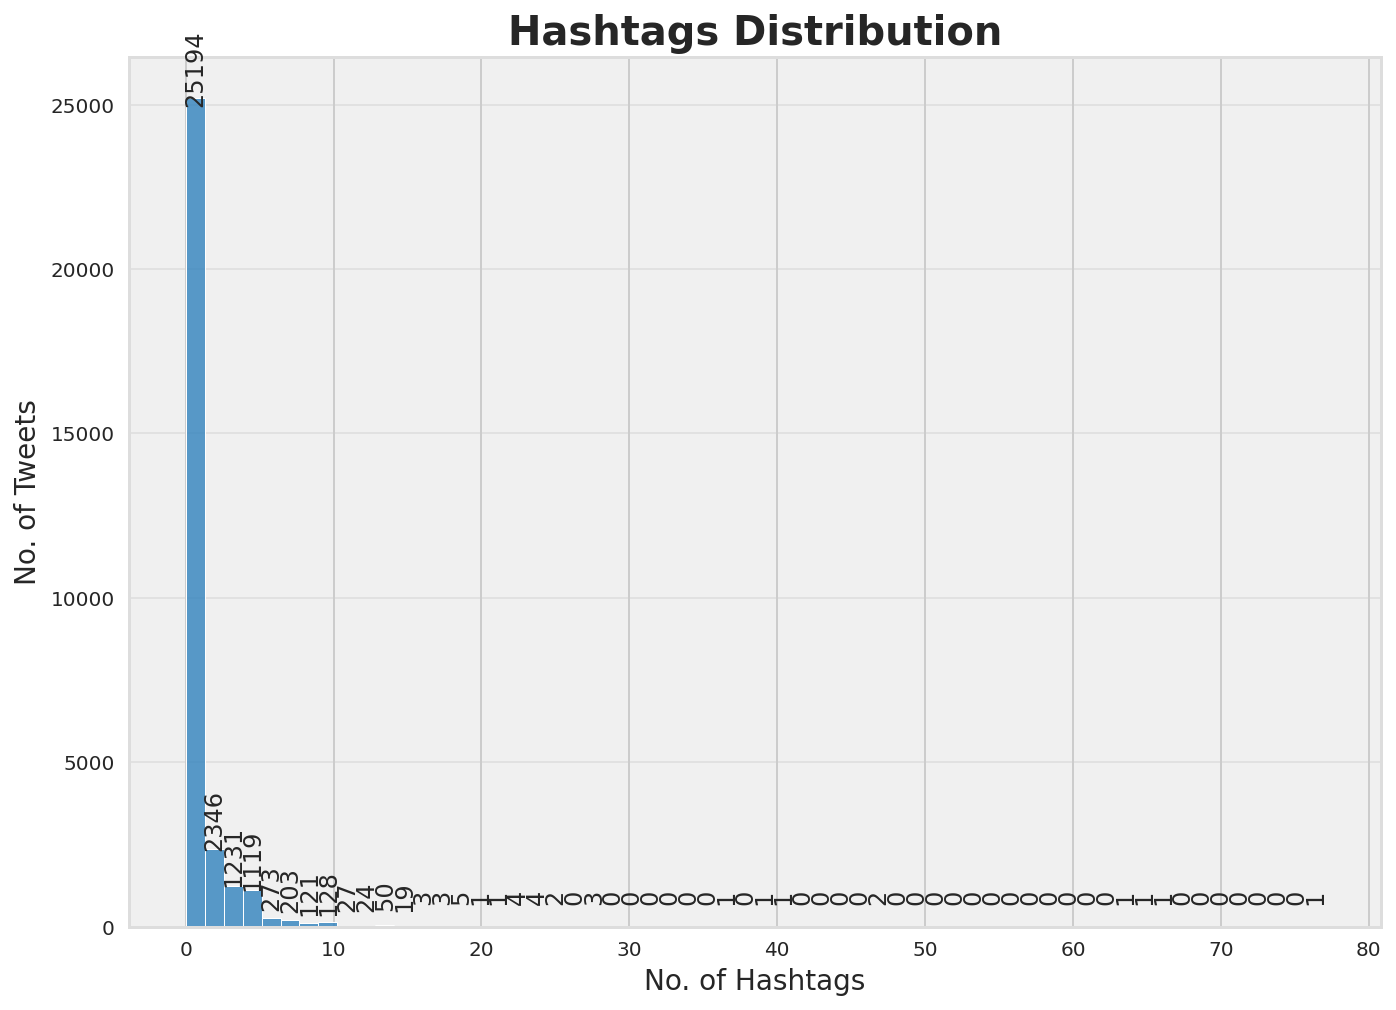

In [ ]:
plot_histogram4(df, 'hashtags', 60, 'Hashtags Distribution', 'No. of Hashtags', 'No. of Tweets')

In [ ]:
# %%HTML

# <div class='tableauPlaceholder' id='viz1622349990436' style='position: relative'><noscript><a href='#'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ha&#47;HateTweetDatabaseEDA&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='HateTweetDatabaseEDA&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ha&#47;HateTweetDatabaseEDA&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1622349990436');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='1227px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

# Preprocessing of Tweets

In [ ]:
df2 = df.copy()
df2.head()

,tweet,target,word_ct,char_ct,avg_wrd,hashtags
0,Drasko they didn't cook half a bird you idiot ...,1,10,50.0,4.100000,1
1,Hopefully someone cooks Drasko in the next ep ...,1,10,53.0,4.400000,1
2,of course you were born in serbia...you're as ...,1,14,75.0,4.428571,1
3,These girls are the equivalent of the irritati...,1,18,99.0,4.555556,1
4,RT @YesYoureRacist: At least you're only a tin...,1,19,102.0,4.421053,0


## Callouts and Retweets

In [ ]:
def collect_and_remove_users(df, col):
    df['retweets'] = df[col].apply(lambda x: re.findall(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', str(x))) # remove re-tweet
    df.retweets = df.retweets.apply(lambda x: str(x)[1:-1])
    df['callouts'] = df[col].apply(lambda x: re.findall(r'(@[A-Za-z0-9-_]+)', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'(@[A-Za-z0-9-_]+)', '', str(x))) # remove tweeted at
    df.callouts = df.callouts.apply(lambda x: str(x)[1:-1])

collect_and_remove_users(df2, 'tweet')
df2.head(20)

,tweet,target,word_ct,char_ct,avg_wrd,hashtags,retweets,callouts
0,Drasko they didn't cook half a bird you idiot ...,1,10,50.0,4.100000,1,,
1,Hopefully someone cooks Drasko in the next ep ...,1,10,53.0,4.400000,1,,
2,of course you were born in serbia...you're as ...,1,14,75.0,4.428571,1,,
3,These girls are the equivalent of the irritati...,1,18,99.0,4.555556,1,,
4,: At least you're only a tiny bit racist : I'm...,1,19,102.0,4.421053,0,"'RT @YesYoureRacist', 'RT @AnMo95'",
5,SANTA JUST *IS* WHITE,1,7,71.0,9.285714,0,,"'@MisfitInChains', '@oldgfatherclock', '@vener..."
6,": Eric Holder from #ferguson: ""I understand th...",1,23,140.0,5.130435,1,'RT @Dreamdefenders',
7,: I spent the morning at the Board of Election...,1,22,140.0,5.409091,1,'RT @AntonioFrench',
8,": In his #Ferguson testimony, Darren Wilson sa...",1,23,140.0,5.130435,1,'RT @harikondabolu',
9,"""He can't be a server at our restaurant, that ...",1,19,120.0,5.368421,1,,


## Character References

In [ ]:
def collect_and_remove_charef(df, col):
    df['charref'] = df[col].apply(lambda x: re.findall(r'&[\S]+?;', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'&[\S]+?;', '', str(x)))
    df.charref = df.charref.apply(lambda x: str(x)[1:-1])

collect_and_remove_charef(df2, 'tweet')
df2.head(20)

,tweet,target,word_ct,char_ct,avg_wrd,hashtags,retweets,callouts,charref
0,Drasko they didn't cook half a bird you idiot ...,1,10,50.0,4.100000,1,,,
1,Hopefully someone cooks Drasko in the next ep ...,1,10,53.0,4.400000,1,,,
2,of course you were born in serbia...you're as ...,1,14,75.0,4.428571,1,,,
3,These girls are the equivalent of the irritati...,1,18,99.0,4.555556,1,,,
4,: At least you're only a tiny bit racist : I'm...,1,19,102.0,4.421053,0,"'RT @YesYoureRacist', 'RT @AnMo95'",,
5,SANTA JUST *IS* WHITE,1,7,71.0,9.285714,0,,"'@MisfitInChains', '@oldgfatherclock', '@vener...",
6,": Eric Holder from #ferguson: ""I understand th...",1,23,140.0,5.130435,1,'RT @Dreamdefenders',,
7,: I spent the morning at the Board of Election...,1,22,140.0,5.409091,1,'RT @AntonioFrench',,
8,": In his #Ferguson testimony, Darren Wilson sa...",1,23,140.0,5.130435,1,'RT @harikondabolu',,
9,"""He can't be a server at our restaurant, that ...",1,19,120.0,5.368421,1,,,


## Hashtags

In [ ]:
def collect_and_remove_hashtags(df, col):
    df['hashtags'] = df[col].apply(lambda x: re.findall(r'(#[A-Za-z]+[A-Za-z0-9-_]+)', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'#', ' ', str(x)))
    df.hashtags = df.hashtags.apply(lambda x: str(x)[1:-1])

collect_and_remove_hashtags(df2, 'tweet')
df2.head(20)

,tweet,target,word_ct,char_ct,avg_wrd,hashtags,retweets,callouts,charref
0,Drasko they didn't cook half a bird you idiot ...,1,10,50.0,4.100000,'#mkr',,,
1,Hopefully someone cooks Drasko in the next ep ...,1,10,53.0,4.400000,'#MKR',,,
2,of course you were born in serbia...you're as ...,1,14,75.0,4.428571,'#MKR',,,
3,These girls are the equivalent of the irritati...,1,18,99.0,4.555556,'#MKR',,,
4,: At least you're only a tiny bit racist : I'm...,1,19,102.0,4.421053,,"'RT @YesYoureRacist', 'RT @AnMo95'",,
5,SANTA JUST *IS* WHITE,1,7,71.0,9.285714,,,"'@MisfitInChains', '@oldgfatherclock', '@vener...",
6,": Eric Holder from ferguson: ""I understand th...",1,23,140.0,5.130435,'#ferguson','RT @Dreamdefenders',,
7,: I spent the morning at the Board of Election...,1,22,140.0,5.409091,'#Ferguson','RT @AntonioFrench',,
8,": In his Ferguson testimony, Darren Wilson sa...",1,23,140.0,5.130435,'#Ferguson','RT @harikondabolu',,
9,"""He can't be a server at our restaurant, that ...",1,19,120.0,5.368421,'#fuckthanksgiving',,,


In [ ]:
df2.hashtags.value_counts()

                                                                                                                                             26433
'#MKR'                                                                                                                                         221
'#mkr'                                                                                                                                         218
'#notsexist'                                                                                                                                    50
'#Yankees'                                                                                                                                      42
                                                                                                                                             ...  
'#chinasucks', '#WuhanVirus'                                                                                          

## QT, Audio, and Video Tags

In [ ]:
def remove_av_qt(df, col):
    """Takes a column of strings in Pandas dataframe and removes AUDIO/VIDEO tags or labels"""    
    df[col] = df[col].apply(lambda x: re.sub(r'(\bQT\b)', '', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'VIDEO:', '', str(x)))
    df[col] = df[col].apply(lambda x: re.sub(r'AUDIO:', '', str(x)))

remove_av_qt(df2, 'tweet')
df2.tweet.head(20)

0     Drasko they didn't cook half a bird you idiot ...
1     Hopefully someone cooks Drasko in the next ep ...
2     of course you were born in serbia...you're as ...
3     These girls are the equivalent of the irritati...
4     : At least you're only a tiny bit racist : I'm...
5                                 SANTA JUST *IS* WHITE
6     : Eric Holder from  ferguson: "I understand th...
7     : I spent the morning at the Board of Election...
8     : In his  Ferguson testimony, Darren Wilson sa...
9     "He can't be a server at our restaurant, that ...
10      Why do people even talk about white privileg...
11                These two are revolting  MKR  MKR2015
12    The menus look like they were made by a 5 year...
13    Wish these blondes were in that How To Get Awa...
14    Were butchers but can't tell red poultry is no...
15    Not dumb blondes...mmm...perhaps just delusion...
16    Stop saying dumb blondes with pretty faces as ...
17     mkr Omg there restaurant looks like a a l

## URLS

In [ ]:
def collect_and_remove_links(df, col):
    df['links'] = df[col].apply(lambda x: re.findall(r'http\S+', str(x))) 
    df[col] = df[col].apply(lambda x: re.sub(r'http\S+', '', str(x)))  # remove http links
    df['links'] = df[col].apply(lambda x: re.findall(r'bit.ly/\S+', str(x))) 
    df[col] = df[col].apply(lambda x: re.sub(r'bit.ly/\S+', '', str(x)))  # remove bit.ly links    
    df.links = df.links.apply(lambda x: str(x)[1:-1]) # remove brackets around list

collect_and_remove_links(df2, "tweet")
df2.head(20)

,tweet,target,word_ct,char_ct,avg_wrd,hashtags,retweets,callouts,charref,links
0,Drasko they didn't cook half a bird you idiot ...,1,10,50.0,4.100000,'#mkr',,,,
1,Hopefully someone cooks Drasko in the next ep ...,1,10,53.0,4.400000,'#MKR',,,,
2,of course you were born in serbia...you're as ...,1,14,75.0,4.428571,'#MKR',,,,
3,These girls are the equivalent of the irritati...,1,18,99.0,4.555556,'#MKR',,,,
4,: At least you're only a tiny bit racist : I'm...,1,19,102.0,4.421053,,"'RT @YesYoureRacist', 'RT @AnMo95'",,,
5,SANTA JUST *IS* WHITE,1,7,71.0,9.285714,,,"'@MisfitInChains', '@oldgfatherclock', '@vener...",,
6,": Eric Holder from ferguson: ""I understand th...",1,23,140.0,5.130435,'#ferguson','RT @Dreamdefenders',,,
7,: I spent the morning at the Board of Election...,1,22,140.0,5.409091,'#Ferguson','RT @AntonioFrench',,,
8,": In his Ferguson testimony, Darren Wilson sa...",1,23,140.0,5.130435,'#Ferguson','RT @harikondabolu',,,
9,"""He can't be a server at our restaurant, that ...",1,19,120.0,5.368421,'#fuckthanksgiving',,,,


## Punctuation

In [ ]:
def remove_punctuation(df, col):    
    df[col] = df[col].apply(lambda x: re.sub(r'[^\w\s]', r'', str(x)))

remove_punctuation(df2, 'tweet')
df2.tweet.head(20)

0     Drasko they didnt cook half a bird you idiot  mkr
1     Hopefully someone cooks Drasko in the next ep ...
2     of course you were born in serbiayoure as fuck...
3     These girls are the equivalent of the irritati...
4      At least youre only a tiny bit racist  Im not...
5                                   SANTA JUST IS WHITE
6      Eric Holder from  ferguson I understand that ...
7      I spent the morning at the Board of Elections...
8      In his  Ferguson testimony Darren Wilson said...
9     He cant be a server at our restaurant that bea...
10      Why do people even talk about white privileg...
11                These two are revolting  MKR  MKR2015
12    The menus look like they were made by a 5 year...
13    Wish these blondes were in that How To Get Awa...
14    Were butchers but cant tell red poultry is not...
15    Not dumb blondesmmmperhaps just delusions of a...
16    Stop saying dumb blondes with pretty faces as ...
17     mkr Omg there restaurant looks like a a l

## Lower Casing

In [ ]:
# lower casing
def lowercasing(df, col):
    df[col] = df[col].apply(lambda x: " ".join(x.lower() for x in x.split()))

lowercasing(df2, 'tweet')
df2.tweet.head(20)

0      drasko they didnt cook half a bird you idiot mkr
1     hopefully someone cooks drasko in the next ep ...
2     of course you were born in serbiayoure as fuck...
3     these girls are the equivalent of the irritati...
4     at least youre only a tiny bit racist im not r...
5                                   santa just is white
6     eric holder from ferguson i understand that mi...
7     i spent the morning at the board of elections ...
8     in his ferguson testimony darren wilson said h...
9     he cant be a server at our restaurant that bea...
10    why do people even talk about white privilege ...
11                  these two are revolting mkr mkr2015
12    the menus look like they were made by a 5 year...
13    wish these blondes were in that how to get awa...
14    were butchers but cant tell red poultry is not...
15    not dumb blondesmmmperhaps just delusions of a...
16    stop saying dumb blondes with pretty faces as ...
17    mkr omg there restaurant looks like a a li

## Numerics

In [ ]:
# remove numbers or words with digits  
def remove_numerics(df, col):
    df[col] = df[col].apply(lambda x: re.sub(r'\w*\d\w*', r'', str(x)))
    

remove_numerics(df2, 'tweet')
df2.tweet.head(20)

0      drasko they didnt cook half a bird you idiot mkr
1     hopefully someone cooks drasko in the next ep ...
2     of course you were born in serbiayoure as fuck...
3     these girls are the equivalent of the irritati...
4     at least youre only a tiny bit racist im not r...
5                                   santa just is white
6     eric holder from ferguson i understand that mi...
7     i spent the morning at the board of elections ...
8     in his ferguson testimony darren wilson said h...
9     he cant be a server at our restaurant that bea...
10    why do people even talk about white privilege ...
11                         these two are revolting mkr 
12    the menus look like they were made by a  year ...
13    wish these blondes were in that how to get awa...
14    were butchers but cant tell red poultry is not...
15    not dumb blondesmmmperhaps just delusions of a...
16    stop saying dumb blondes with pretty faces as ...
17    mkr omg there restaurant looks like a a li

## Whitespaces

In [ ]:
def remove_whitespaces(df, col):
    df[col] = df[col].apply(lambda x: re.sub(r'\s\s+', ' ', str(x))) # remove any double or more whitespaces to single whitespaces
    df[col] = df[col].apply(lambda x: re.sub(r'(\A\s+|\s+\Z)', '', str(x))) # remove any leading and trailing whitespace

remove_whitespaces(df2, 'tweet')
df2.tweet.head(20)

0      drasko they didnt cook half a bird you idiot mkr
1     hopefully someone cooks drasko in the next ep ...
2     of course you were born in serbiayoure as fuck...
3     these girls are the equivalent of the irritati...
4     at least youre only a tiny bit racist im not r...
5                                   santa just is white
6     eric holder from ferguson i understand that mi...
7     i spent the morning at the board of elections ...
8     in his ferguson testimony darren wilson said h...
9     he cant be a server at our restaurant that bea...
10    why do people even talk about white privilege ...
11                          these two are revolting mkr
12    the menus look like they were made by a year o...
13    wish these blondes were in that how to get awa...
14    were butchers but cant tell red poultry is not...
15    not dumb blondesmmmperhaps just delusions of a...
16    stop saying dumb blondes with pretty faces as ...
17    mkr omg there restaurant looks like a a li

## Tokenization and Lemmatization

In [ ]:
import gensim
import nltk
import gensim.parsing.preprocessing

def lemmatize(token):
    """Returns lemmatization of a token"""
    return WordNetLemmatizer().lemmatize(token, pos='v')

def tokenize(tweet):
    """Returns tokenized representation of words in lemma form excluding stopwords"""
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS \
                and len(token) > 2:  # drops words with less than 3 characters
            result.append(lemmatize(token))
    return result

def tokenize_and_lemmatize(df, col):
    df[col] = df[col].apply(lambda x: tokenize(x))
    df.tweet = df.tweet.apply(lambda x: str(x)[1:-1])

tokenize_and_lemmatize(df2, 'tweet')
df2.tweet.head(20)


0     'drasko', 'didnt', 'cook', 'half', 'bird', 'id...
1                  'hopefully', 'cook', 'drasko', 'mkr'
2     'course', 'bear', 'serbiayoure', 'fuck', 'serb...
3     'girls', 'equivalent', 'irritate', 'asian', 'g...
4     'youre', 'tiny', 'bite', 'racist', 'racist', '...
5                                      'santa', 'white'
6     'eric', 'holder', 'ferguson', 'understand', 'm...
7     'spend', 'morning', 'board', 'elections', 'get...
8     'ferguson', 'testimony', 'darren', 'wilson', '...
9     'server', 'restaurant', 'beard', 'make', 'look...
10    'people', 'talk', 'white', 'privilege', 'major...
11                                      'revolt', 'mkr'
12    'menus', 'look', 'like', 'year', 'old', 'littl...
13           'wish', 'blondes', 'away', 'murder', 'mkr'
14    'butcher', 'tell', 'red', 'poultry', 'cook', '...
15               'dumb', 'delusions', 'adequacy', 'mkr'
16    'stop', 'say', 'dumb', 'blondes', 'pretty', 'f...
17    'mkr', 'omg', 'restaurant', 'look', 'like'

# Preprocessing

In [ ]:
df3 = df.copy()

In [ ]:
df3.head()

,tweet,target,word_ct,char_ct,avg_wrd,hashtags
0,Drasko they didn't cook half a bird you idiot ...,1,10,50.0,4.100000,1
1,Hopefully someone cooks Drasko in the next ep ...,1,10,53.0,4.400000,1
2,of course you were born in serbia...you're as ...,1,14,75.0,4.428571,1
3,These girls are the equivalent of the irritati...,1,18,99.0,4.555556,1
4,RT @YesYoureRacist: At least you're only a tin...,1,19,102.0,4.421053,0


## Preprocessing Function

- Letter casing: Converting all letters to either upper case or lower case.
- Tokenizing: Turning the tweets into tokens. Tokens are words separated by spaces in a text.
- Noise removal: Eliminating unwanted characters, such as HTML tags, punctuation marks, special characters, white spaces etc.
- Stopword removal: Some words do not contribute much to the machine learning model, so it's good to remove them. A list of stopwords can be defined by the nltk library, or it can be business-specific.
- Normalization: Normalization generally refers to a series of related tasks meant to put all text on the same level. Converting text to lower case, removing special characters, and removing stopwords will remove basic inconsistencies. Normalization improves text matching.
- Stemming: Eliminating affixes (circumfixes, suffixes, prefixes, infixes) from a word in order to obtain a word stem. Porter Stemmer is the most widely used technique because it is very fast. Generally, stemming chops off end of the word, and mostly it works fine. Example: Working -> Work
- Lemmatization: The goal is same as with stemming, but stemming a word sometimes loses the actual meaning of the word. Lemmatization usually refers to doing things properly using vocabulary and morphological analysis of words. It returns the base or dictionary form of a word, also known as the lemma. Example: Better -> Good.
    - Stemming is faster than lemmatization. You can uncomment the code and see how results change. Note: Do not apply both. Remember that stemming and lemmatization are normalization techniques, and it is recommended to use only one approach to normalize. Let your project requirements guide your decision, or you can always do experiments and see which one gives better results. In this case, stemming and lemmatizing yield almost the same accuracy.
- Vectorizing Data: Vectorizing is the process to convert tokens to numbers. It is an important step because the machine learning algorithm works with numbers and not text, such as vectorization using tf-idf, or Bag of Words and N-grams.

In [ ]:
preprocess_tweets(df3, 'tweet')

,tweet,target,word_ct,char_ct,avg_wrd,hashtags
0,"'drasko', 'they', 'didnt', 'cook', 'half', 'bi...",1,10,50.0,4.100000,1
1,"'hopefully', 'someone', 'cook', 'drasko', 'the...",1,10,53.0,4.400000,1
2,"'course', 'you', 'be', 'bear', 'serbiayoure', ...",1,14,75.0,4.428571,1
3,"'these', 'girls', 'be', 'the', 'equivalent', '...",1,18,99.0,4.555556,1
4,"'least', 'youre', 'only', 'tiny', 'bite', 'rac...",1,19,102.0,4.421053,0
...,...,...,...,...,...,...
30765,"'yous', 'muthafin', 'lie', 'right', 'his', 'tr...",0,19,146.0,6.736842,3
30766,"'youve', 'go', 'and', 'break', 'the', 'wrong',...",0,13,70.0,4.461538,0
30767,"'young', 'buck', 'wan', 'eat', 'dat', 'nigguh'...",0,13,67.0,4.230769,0
30768,"'youu', 'get', 'wild', 'bitch', 'tellin', 'you...",0,7,37.0,4.428571,0


In [ ]:
df3.head()

,tweet,target,word_ct,char_ct,avg_wrd,hashtags
0,"'drasko', 'they', 'didnt', 'cook', 'half', 'bi...",1,10,50.0,4.100000,1
1,"'hopefully', 'someone', 'cook', 'drasko', 'the...",1,10,53.0,4.400000,1
2,"'course', 'you', 'be', 'bear', 'serbiayoure', ...",1,14,75.0,4.428571,1
3,"'these', 'girls', 'be', 'the', 'equivalent', '...",1,18,99.0,4.555556,1
4,"'least', 'youre', 'only', 'tiny', 'bite', 'rac...",1,19,102.0,4.421053,0


In [ ]:
df3['tweet'][0]

"'drasko', 'they', 'didnt', 'cook', 'half', 'bird', 'you', 'idiot', 'mkr'"

In [ ]:
def clean_tweet_string(tweet_str):
    # Remove leading and trailing quotes
    tweet_str = tweet_str.strip("'")
    
    # Split the string by commas
    tweet_list = tweet_str.split(", ")
    
    # Remove quotes from each item in the list
    tweet_list = [item.strip("'") for item in tweet_list]
    
    return tweet_list

# Apply the function to the 'tweet' column in the dataframe
df3['tweet'] = df3['tweet'].apply(clean_tweet_string)


In [ ]:
df3.head()

,tweet,target,word_ct,char_ct,avg_wrd,hashtags
0,"[drasko, they, didnt, cook, half, bird, you, i...",1,10,50.0,4.100000,1
1,"[hopefully, someone, cook, drasko, the, next, ...",1,10,53.0,4.400000,1
2,"[course, you, be, bear, serbiayoure, fuck, ser...",1,14,75.0,4.428571,1
3,"[these, girls, be, the, equivalent, the, irrit...",1,18,99.0,4.555556,1
4,"[least, youre, only, tiny, bite, racist, not, ...",1,19,102.0,4.421053,0


## Distribution of Class Counts

In [ ]:
df3['target'].value_counts()

0    23353
1     7417
Name: target, dtype: int64

In [ ]:
hate = df3[df3.target == 1]
non_hate = df3[df3.target == 0]

## Train-Validation-Test-Split

In [ ]:
X_h = hate.tweet
y_h = hate.target
X_nh = non_hate.tweet
y_nh = non_hate.target

In [ ]:
X_h_tr, X_h_val, y_h_tr, y_h_val = train_test_split(X_h, y_h, test_size=0.25, random_state=42)
X_h_val, X_h_tt, y_h_val, y_h_tt = train_test_split(X_h_val, y_h_val, test_size=0.4, random_state=42)
X_nh_tr, X_nh_val, y_nh_tr, y_nh_val = train_test_split(X_nh, y_nh, test_size=0.25, random_state=42)
X_nh_val, X_nh_tt, y_nh_val, y_nh_tt = train_test_split(X_nh_val, y_nh_val, test_size=0.4, random_state=42)

In [ ]:
X_tr = pd.concat((X_h_tr, X_nh_tr), ignore_index=True)
y_tr = pd.concat((y_h_tr, y_nh_tr), ignore_index=True)
train = pd.concat([X_tr, y_tr], axis=1)
train

,tweet,target
0,"[all, responsible, for, the, chinese, communis...",1
1,"[not, sexist, but, leave, some, girl, write, a...",1
2,"[whos, work, these, months, cover, shit, for, ...",1
3,"[mkr, why, all, these, people, want, cook, for...",1
4,"[how, about, you, unfollow, while, you, be, fe...",1
...,...,...
23071,"[miss, you, lil, bitch]",0
23072,"[why, you, get, such, hoe, smh, aint, captain,...",0
23073,"[lmao, yeah, bitch, that, lil, shit, rip]",0
23074,"[tbt, be, bad, bitch]",0


In [ ]:
train['tweet2'] = train.tweet.apply(lambda x: str(x)[1:-1]) 
train

,tweet,target,tweet2
0,"[all, responsible, for, the, chinese, communis...",1,"'all', 'responsible', 'for', 'the', 'chinese',..."
1,"[not, sexist, but, leave, some, girl, write, a...",1,"'not', 'sexist', 'but', 'leave', 'some', 'girl..."
2,"[whos, work, these, months, cover, shit, for, ...",1,"'whos', 'work', 'these', 'months', 'cover', 's..."
3,"[mkr, why, all, these, people, want, cook, for...",1,"'mkr', 'why', 'all', 'these', 'people', 'want'..."
4,"[how, about, you, unfollow, while, you, be, fe...",1,"'how', 'about', 'you', 'unfollow', 'while', 'y..."
...,...,...,...
23071,"[miss, you, lil, bitch]",0,"'miss', 'you', 'lil', 'bitch'"
23072,"[why, you, get, such, hoe, smh, aint, captain,...",0,"'why', 'you', 'get', 'such', 'hoe', 'smh', 'ai..."
23073,"[lmao, yeah, bitch, that, lil, shit, rip]",0,"'lmao', 'yeah', 'bitch', 'that', 'lil', 'shit'..."
23074,"[tbt, be, bad, bitch]",0,"'tbt', 'be', 'bad', 'bitch'"


In [ ]:
X_val = pd.concat((X_h_val, X_nh_val), ignore_index=True)
y_val = pd.concat((y_h_val, y_nh_val), ignore_index=True)
val = pd.concat([X_val, y_val], axis=1)
val

,tweet,target
0,"[the, film, jennifer, lopez, play, rapist, tha...",1
1,"[niggaz, like, all, them, naked, bitch, pics, ...",1
2,"[please, stop, eat, dog, cat, bat, pangolins, ...",1
3,"[seei, specifically, leave, those, out, becaus...",1
4,"[when, niggas, ask, where, the, hoe]",1
...,...,...
4611,"[yeah, some, niggas, be, straight, bitch]",0
4612,"[get, pay, too, chill, share, the, wealth, lil...",0
4613,"[bruh, them, ugly, hoe, say, nigga, arrogant]",0
4614,"[lol, that, caitlyn, cant, carry, retard]",0


In [ ]:
val['tweet2'] = val.tweet.apply(lambda x: str(x)[1:-1]) 
val

,tweet,target,tweet2
0,"[the, film, jennifer, lopez, play, rapist, tha...",1,"'the', 'film', 'jennifer', 'lopez', 'play', 'r..."
1,"[niggaz, like, all, them, naked, bitch, pics, ...",1,"'niggaz', 'like', 'all', 'them', 'naked', 'bit..."
2,"[please, stop, eat, dog, cat, bat, pangolins, ...",1,"'please', 'stop', 'eat', 'dog', 'cat', 'bat', ..."
3,"[seei, specifically, leave, those, out, becaus...",1,"'seei', 'specifically', 'leave', 'those', 'out..."
4,"[when, niggas, ask, where, the, hoe]",1,"'when', 'niggas', 'ask', 'where', 'the', 'hoe'"
...,...,...,...
4611,"[yeah, some, niggas, be, straight, bitch]",0,"'yeah', 'some', 'niggas', 'be', 'straight', 'b..."
4612,"[get, pay, too, chill, share, the, wealth, lil...",0,"'get', 'pay', 'too', 'chill', 'share', 'the', ..."
4613,"[bruh, them, ugly, hoe, say, nigga, arrogant]",0,"'bruh', 'them', 'ugly', 'hoe', 'say', 'nigga',..."
4614,"[lol, that, caitlyn, cant, carry, retard]",0,"'lol', 'that', 'caitlyn', 'cant', 'carry', 're..."


In [ ]:
X_tt = pd.concat((X_h_tt, X_nh_tt), ignore_index=True)
y_tt = pd.concat((y_h_tt, y_nh_tt), ignore_index=True)
test = pd.concat([X_tt, y_tt], axis=1)
test

,tweet,target
0,"[just, wan, slit, this, throat]",1
1,"[damn, they, get, wifey, fall, back, nigga, do...",1
2,"[the, mine, place, for, woman, work, call, sex...",1
3,"[call, sexist, but, when, auto, place, rather,...",1
4,"[selfawareness, critically, low, level, not, s...",1
...,...,...
3073,"[you, owe, two, hoe, dont, wan, hear, shit, wh...",0
3074,"[addict, twitter, just, side, bitch]",0
3075,"[thats, why, youre, good, this, game, cause, s...",0
3076,"[dont, give, man, the, pussy, until, give, you...",0


In [ ]:
test['target'].value_counts()

0    2336
1     742
Name: target, dtype: int64

In [ ]:
test.to_csv("test.csv", index=False)

## Separate into classes

In [ ]:
zero = train[train.target == 0]
zero.head()

,tweet,target,tweet2
5562,"[you, bitch]",0,"'you', 'bitch'"
5563,"[take, this, bitch, months, put, scarf, smfh]",0,"'take', 'this', 'bitch', 'months', 'put', 'sca..."
5564,"[kim, alright, but, honestly, many, niggas, be...",0,"'kim', 'alright', 'but', 'honestly', 'many', '..."
5565,"[that, bitch, be, worry, about, fin, fuck, you...",0,"'that', 'bitch', 'be', 'worry', 'about', 'fin'..."
5566,"[end, the, ordination, women, and, faggot, who...",0,"'end', 'the', 'ordination', 'women', 'and', 'f..."


In [ ]:
one = train[train.target == 1]
one.head()

,tweet,target,tweet2
0,"[all, responsible, for, the, chinese, communis...",1,"'all', 'responsible', 'for', 'the', 'chinese',..."
1,"[not, sexist, but, leave, some, girl, write, a...",1,"'not', 'sexist', 'but', 'leave', 'some', 'girl..."
2,"[whos, work, these, months, cover, shit, for, ...",1,"'whos', 'work', 'these', 'months', 'cover', 's..."
3,"[mkr, why, all, these, people, want, cook, for...",1,"'mkr', 'why', 'all', 'these', 'people', 'want'..."
4,"[how, about, you, unfollow, while, you, be, fe...",1,"'how', 'about', 'you', 'unfollow', 'while', 'y..."


In [ ]:
print(len(zero))
len(one)

17514


5562

In [ ]:
zero_tokens = zero.tweet.sum()
zero_tokens[:20]

['you',
 'bitch',
 'take',
 'this',
 'bitch',
 'months',
 'put',
 'scarf',
 'smfh',
 'kim',
 'alright',
 'but',
 'honestly',
 'many',
 'niggas',
 'be',
 'that',
 'rather',
 'not',
 'and']

In [ ]:
one_tokens = one.tweet.sum()
one_tokens[:20]

['all',
 'responsible',
 'for',
 'the',
 'chinese',
 'communist',
 'party',
 'chinese',
 'virus',
 'not',
 'sexist',
 'but',
 'leave',
 'some',
 'girl',
 'write',
 'article',
 'espn',
 'about',
 'why']

## Frequency Distributions

In [ ]:
vec = CountVectorizer()
docs = vec.fit_transform(zero_tokens)
features = vec.get_feature_names_out()

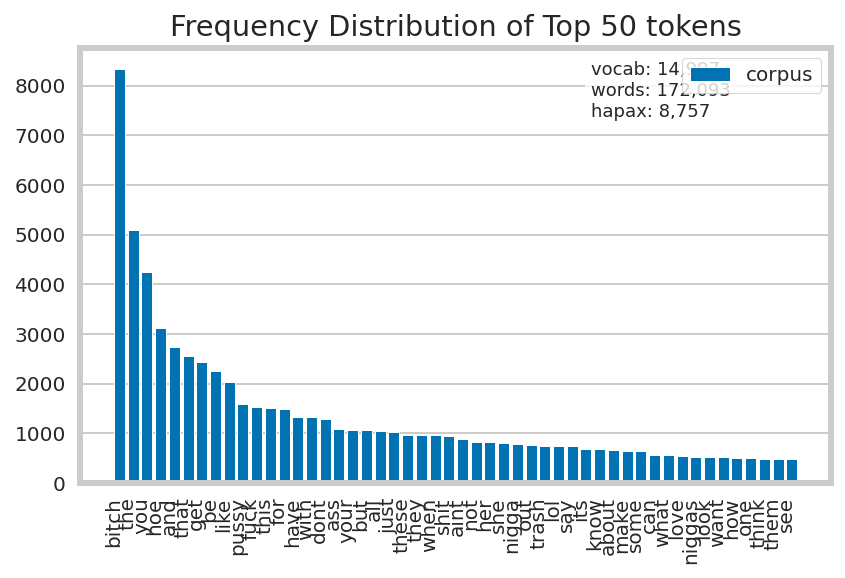

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [ ]:
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

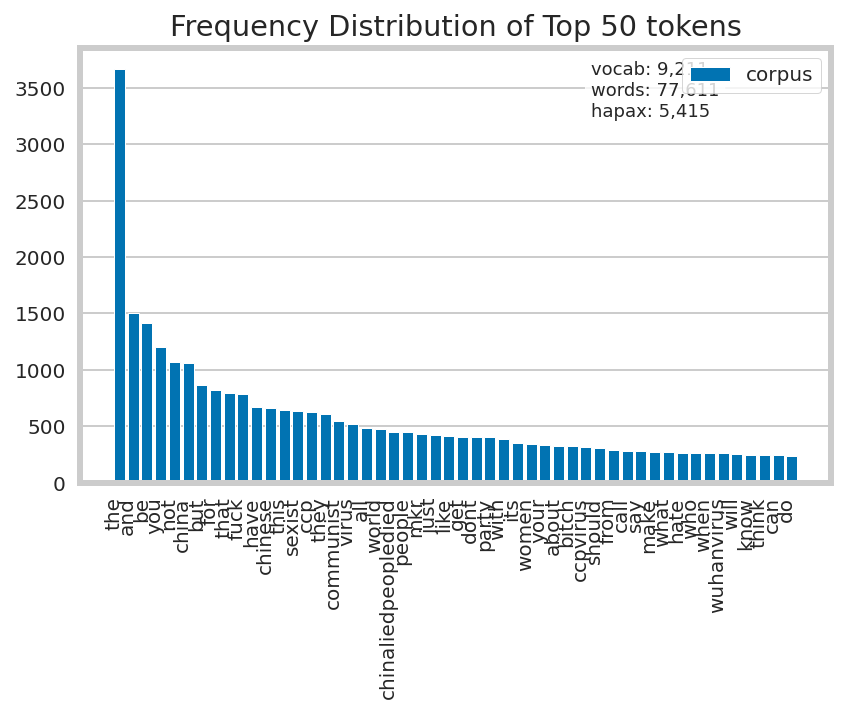

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [ ]:
vec = CountVectorizer()
docs = vec.fit_transform(one_tokens)
features = vec.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

## TSNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 23076 samples in 0.002s...
[t-SNE] Computed neighbors for 23076 samples in 4.338s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23076
[t-SNE] Computed conditional probabilities for sample 2000 / 23076
[t-SNE] Computed conditional probabilities for sample 3000 / 23076
[t-SNE] Computed conditional probabilities for sample 4000 / 23076
[t-SNE] Computed conditional probabilities for sample 5000 / 23076
[t-SNE] Computed conditional probabilities for sample 6000 / 23076
[t-SNE] Computed conditional probabilities for sample 7000 / 23076
[t-SNE] Computed conditional probabilities for sample 8000 / 23076
[t-SNE] Computed conditional probabilities for sample 9000 / 23076
[t-SNE] Computed conditional probabilities for sample 10000 / 23076
[t-SNE] Computed conditional probabilities for sample 11000 / 23076
[t-SNE] Computed conditional probabilities for sample 12000 / 23076
[t-SNE] Computed conditional probabilities for sam

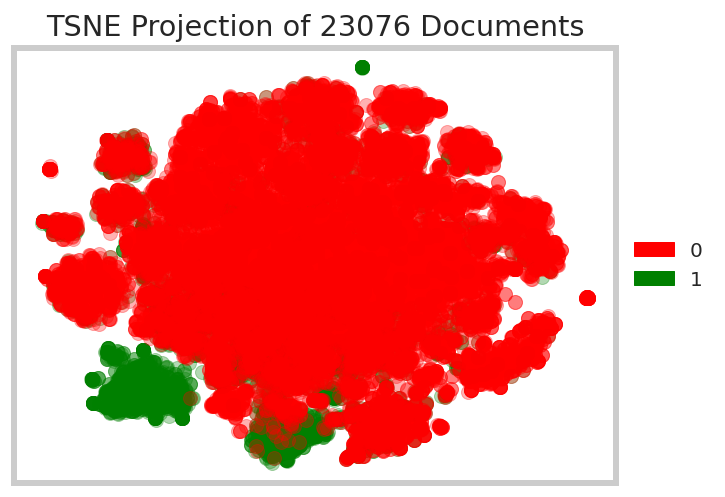

AttributeError: ignored

AttributeError: ignored

AttributeError: ignored

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(train.tweet2)
y = train.target

tsne(X, y, alpha=0.3, decompose='svd', colors=['red','green'], verbose=1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17514 samples in 0.002s...
[t-SNE] Computed neighbors for 17514 samples in 3.312s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17514
[t-SNE] Computed conditional probabilities for sample 2000 / 17514
[t-SNE] Computed conditional probabilities for sample 3000 / 17514
[t-SNE] Computed conditional probabilities for sample 4000 / 17514
[t-SNE] Computed conditional probabilities for sample 5000 / 17514
[t-SNE] Computed conditional probabilities for sample 6000 / 17514
[t-SNE] Computed conditional probabilities for sample 7000 / 17514
[t-SNE] Computed conditional probabilities for sample 8000 / 17514
[t-SNE] Computed conditional probabilities for sample 9000 / 17514
[t-SNE] Computed conditional probabilities for sample 10000 / 17514
[t-SNE] Computed conditional probabilities for sample 11000 / 17514
[t-SNE] Computed conditional probabilities for sample 12000 / 17514
[t-SNE] Computed conditional probabilities for sam

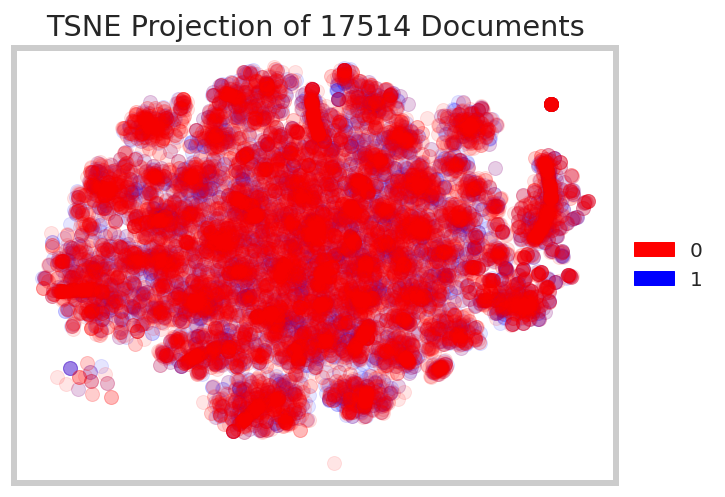

AttributeError: ignored

AttributeError: ignored

AttributeError: ignored

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(zero.tweet2)
y = train.target

tsne(X, y, alpha=0.1, decompose='svd',colors=['red','blue'], verbose=1)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5562 samples in 0.001s...
[t-SNE] Computed neighbors for 5562 samples in 0.425s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5562
[t-SNE] Computed conditional probabilities for sample 2000 / 5562
[t-SNE] Computed conditional probabilities for sample 3000 / 5562
[t-SNE] Computed conditional probabilities for sample 4000 / 5562
[t-SNE] Computed conditional probabilities for sample 5000 / 5562
[t-SNE] Computed conditional probabilities for sample 5562 / 5562
[t-SNE] Mean sigma: 0.051586
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.967270
[t-SNE] KL divergence after 1000 iterations: 1.866028


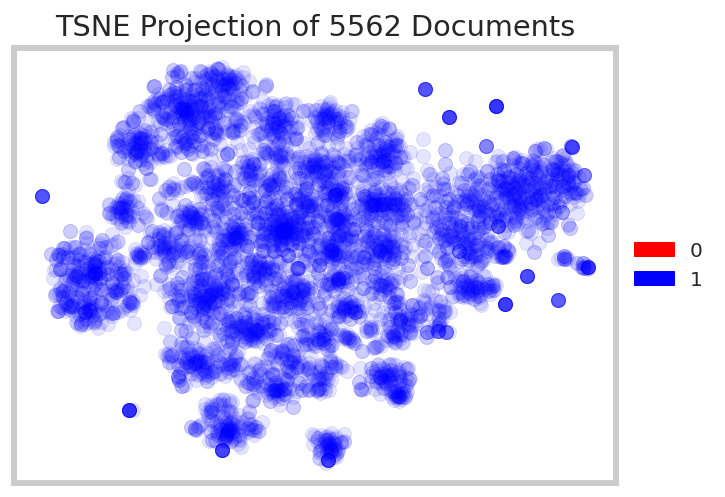

AttributeError: ignored

AttributeError: ignored

AttributeError: ignored

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(one.tweet2)
y = train.target

tsne(X, y, alpha=0.1, decompose='svd',colors=['red','blue'], verbose=1)

## Wordcloud

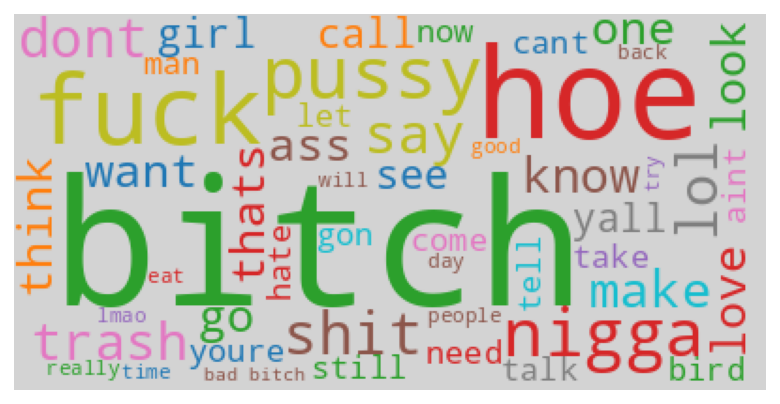

In [ ]:
text = ' '.join(zero_tokens)

# Initialize wordcloud object
wc = WordCloud(background_color='lightgray', colormap='tab10', max_words=50)

# Generate and plot wordcloud
plt.imshow(wc.generate(text))
plt.axis('off')
plt.show()

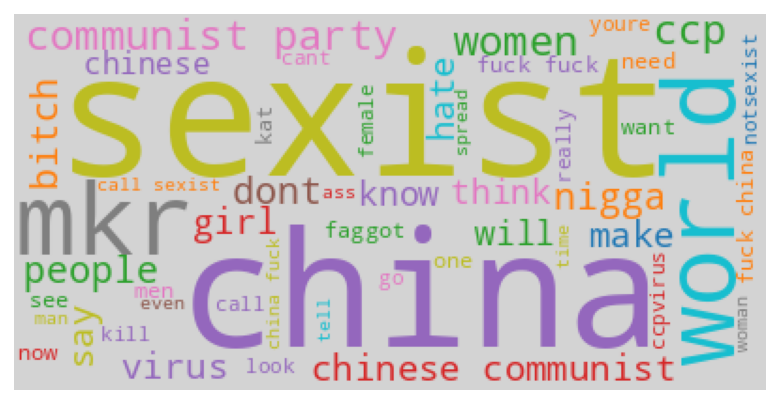

In [ ]:
text = ' '.join(one_tokens)

# Initialize wordcloud object
wc = WordCloud( background_color='lightgray', colormap='tab10', max_words=50)

# Generate and plot wordcloud
plt.imshow(wc.generate(text))
plt.axis('off')
plt.show()

## Bigrams

In [ ]:
def combination_of_words(df):
    return TextBlob(" ".join(train.tweet.sum())).ngrams(2)

In [ ]:
combination_of_words(zero)[:50]

[WordList(['all', 'responsible']),
 WordList(['responsible', 'for']),
 WordList(['for', 'the']),
 WordList(['the', 'chinese']),
 WordList(['chinese', 'communist']),
 WordList(['communist', 'party']),
 WordList(['party', 'chinese']),
 WordList(['chinese', 'virus']),
 WordList(['virus', 'not']),
 WordList(['not', 'sexist']),
 WordList(['sexist', 'but']),
 WordList(['but', 'leave']),
 WordList(['leave', 'some']),
 WordList(['some', 'girl']),
 WordList(['girl', 'write']),
 WordList(['write', 'article']),
 WordList(['article', 'espn']),
 WordList(['espn', 'about']),
 WordList(['about', 'why']),
 WordList(['why', 'people']),
 WordList(['people', 'be']),
 WordList(['be', 'angry']),
 WordList(['angry', 'ncaab']),
 WordList(['ncaab', 'this']),
 WordList(['this', 'year']),
 WordList(['year', 'whos']),
 WordList(['whos', 'work']),
 WordList(['work', 'these']),
 WordList(['these', 'months']),
 WordList(['months', 'cover']),
 WordList(['cover', 'shit']),
 WordList(['shit', 'for']),
 WordList(['for'

In [ ]:
combination_of_words(one)[:50]

[WordList(['all', 'responsible']),
 WordList(['responsible', 'for']),
 WordList(['for', 'the']),
 WordList(['the', 'chinese']),
 WordList(['chinese', 'communist']),
 WordList(['communist', 'party']),
 WordList(['party', 'chinese']),
 WordList(['chinese', 'virus']),
 WordList(['virus', 'not']),
 WordList(['not', 'sexist']),
 WordList(['sexist', 'but']),
 WordList(['but', 'leave']),
 WordList(['leave', 'some']),
 WordList(['some', 'girl']),
 WordList(['girl', 'write']),
 WordList(['write', 'article']),
 WordList(['article', 'espn']),
 WordList(['espn', 'about']),
 WordList(['about', 'why']),
 WordList(['why', 'people']),
 WordList(['people', 'be']),
 WordList(['be', 'angry']),
 WordList(['angry', 'ncaab']),
 WordList(['ncaab', 'this']),
 WordList(['this', 'year']),
 WordList(['year', 'whos']),
 WordList(['whos', 'work']),
 WordList(['work', 'these']),
 WordList(['these', 'months']),
 WordList(['months', 'cover']),
 WordList(['cover', 'shit']),
 WordList(['shit', 'for']),
 WordList(['for'

## Term Frequency

In [ ]:
def term_frequency(df):
    tf1 = (df['tweet2'].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index())
    tf1.columns = ['words', 'tf']
    tf1 = tf1.sort_values(by='tf', ascending=False).reset_index()
    return tf1

In [ ]:
tf1 = term_frequency(zero)

In [ ]:
tf1.head(10)

,index,words,tf
0,4,"'bitch',",6418.0
1,28,"'the',",5069.0
2,0,"'you',",4063.0
3,16,"'and',",2730.0
4,9,"'that',",2451.0
5,14,"'get',",2412.0
6,119,"'hoe',",2280.0
7,19,"'be',",2218.0
8,115,"'like',",1924.0
9,1,'bitch',1918.0


In [ ]:
tf2 = term_frequency(one)

In [ ]:
tf2.head(10)

,index,words,tf
0,4,"'the',",3653.0
1,25,"'and',",1501.0
2,13,"'be',",1390.0
3,69,"'you',",1165.0
4,8,"'not',",1061.0
5,49,"'china',",1013.0
6,23,"'but',",865.0
7,3,"'for',",802.0
8,103,"'fuck',",771.0
9,155,"'that',",767.0


In [ ]:
train.head()

,tweet,target,tweet2
0,"[all, responsible, for, the, chinese, communis...",1,"'all', 'responsible', 'for', 'the', 'chinese',..."
1,"[not, sexist, but, leave, some, girl, write, a...",1,"'not', 'sexist', 'but', 'leave', 'some', 'girl..."
2,"[whos, work, these, months, cover, shit, for, ...",1,"'whos', 'work', 'these', 'months', 'cover', 's..."
3,"[mkr, why, all, these, people, want, cook, for...",1,"'mkr', 'why', 'all', 'these', 'people', 'want'..."
4,"[how, about, you, unfollow, while, you, be, fe...",1,"'how', 'about', 'you', 'unfollow', 'while', 'y..."


In [ ]:
val['target'].value_counts()

0    3503
1    1113
Name: target, dtype: int64

In [ ]:
val.head()

,tweet,target,tweet2
0,"[the, film, jennifer, lopez, play, rapist, tha...",1,"'the', 'film', 'jennifer', 'lopez', 'play', 'r..."
1,"[niggaz, like, all, them, naked, bitch, pics, ...",1,"'niggaz', 'like', 'all', 'them', 'naked', 'bit..."
2,"[please, stop, eat, dog, cat, bat, pangolins, ...",1,"'please', 'stop', 'eat', 'dog', 'cat', 'bat', ..."
3,"[seei, specifically, leave, those, out, becaus...",1,"'seei', 'specifically', 'leave', 'those', 'out..."
4,"[when, niggas, ask, where, the, hoe]",1,"'when', 'niggas', 'ask', 'where', 'the', 'hoe'"


In [ ]:
val.shape

(4616, 3)

In [ ]:
train.to_csv('train.csv', index=False)
val.to_csv('val.csv', index=False)